# **LIBRARIES IMPORTING**

In [1]:
import os

import random
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate

# **DATASET**

In [2]:
img_size = 128

In [3]:
x_train_cxr = np.load('/kaggle/input/pneumonia-detection-datasets/chest-xray/train/images.npy')
x_train_ch0 = np.load('/kaggle/input/pneumonia-detection-datasets/segment/train/images.npy')
x_train_ch1 = np.load('/kaggle/input/pneumonia-detection-datasets/segment_with_convexhull/train/images.npy')
y_train = np.load('/kaggle/input/pneumonia-detection-datasets/chest-xray/train/labels.npy')

x_test_cxr = np.load('/kaggle/input/pneumonia-detection-datasets/chest-xray/test/images.npy')
x_test_ch0 = np.load('/kaggle/input/pneumonia-detection-datasets/segment/test/images.npy')
x_test_ch1 = np.load('/kaggle/input/pneumonia-detection-datasets/segment_with_convexhull/test/images.npy')
y_test = np.load('/kaggle/input/pneumonia-detection-datasets/chest-xray/test/labels.npy')

print(np.shape(x_train_cxr))
print(np.shape(x_train_ch0))
print(np.shape(x_train_ch1))
print(np.shape(y_train))
print(np.shape(x_test_cxr))
print(np.shape(x_test_ch0))
print(np.shape(x_test_ch1))
print(np.shape(y_test))

(5232, 128, 128, 1)
(5232, 128, 128, 1)
(5232, 128, 128, 1)
(5232,)
(624, 128, 128, 1)
(624, 128, 128, 1)
(624, 128, 128, 1)
(624,)


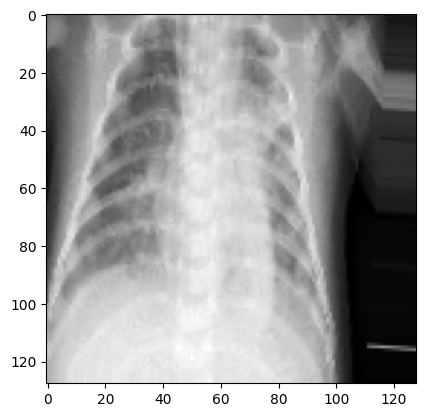

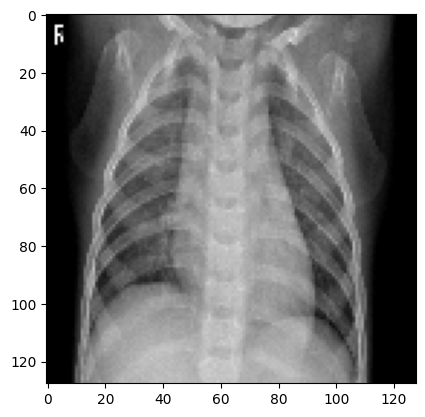

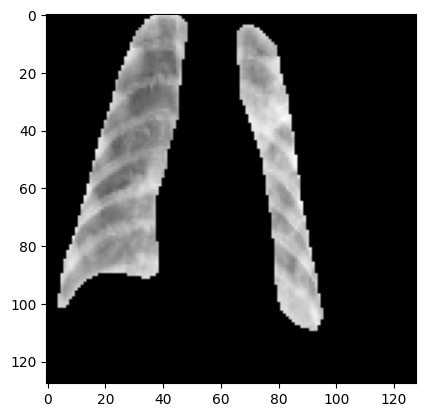

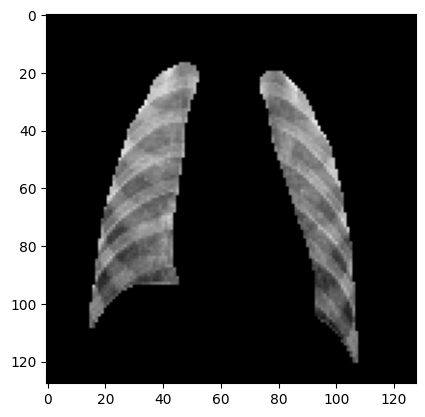

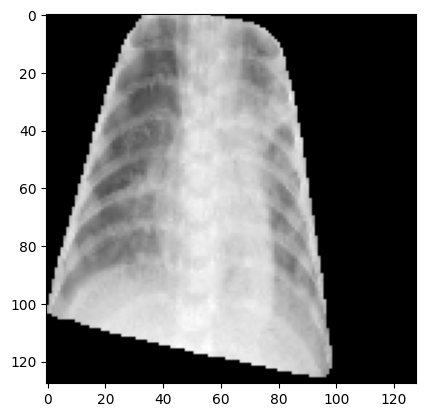

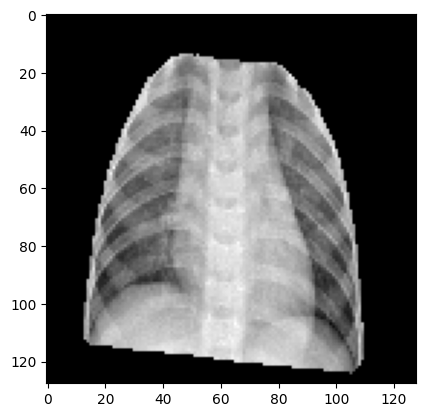

In [4]:
plt.imshow(x_train_cxr[0], cmap='gray')
plt.show()
plt.imshow(x_test_cxr[0], cmap='gray')
plt.show()

plt.imshow(x_train_ch0[0], cmap='gray')
plt.show()
plt.imshow(x_test_ch0[0], cmap='gray')
plt.show()

plt.imshow(x_train_ch1[0], cmap='gray')
plt.show()
plt.imshow(x_test_ch1[0], cmap='gray')
plt.show()

In [5]:
x_train_cxr = x_train_cxr.reshape(-1, img_size, img_size)
x_train_rgb_cxr = np.stack((x_train_cxr,) * 3, axis=-1)
x_train_ch0 = x_train_ch0.reshape(-1, img_size, img_size)
x_train_rgb_ch0 = np.stack((x_train_ch0,) * 3, axis=-1)
x_train_ch1 = x_train_ch1.reshape(-1, img_size, img_size)
x_train_rgb_ch1 = np.stack((x_train_ch1,) * 3, axis=-1)

x_test_cxr = x_test_cxr.reshape(-1, img_size, img_size)
x_test_rgb_cxr = np.stack((x_test_cxr,) * 3, axis=-1)
x_test_ch0 = x_test_ch0.reshape(-1, img_size, img_size)
x_test_rgb_ch0 = np.stack((x_test_ch0,) * 3, axis=-1)
x_test_ch1 = x_test_ch1.reshape(-1, img_size, img_size)
x_test_rgb_ch1 = np.stack((x_test_ch1,) * 3, axis=-1)

print(np.shape(x_train_rgb_cxr))
print(np.shape(x_train_rgb_ch0))
print(np.shape(x_train_rgb_ch1))
print(np.shape(y_train))
print(np.shape(x_test_rgb_cxr))
print(np.shape(x_test_rgb_ch0))
print(np.shape(x_test_rgb_ch1))
print(np.shape(y_test))

(5232, 128, 128, 3)
(5232, 128, 128, 3)
(5232, 128, 128, 3)
(5232,)
(624, 128, 128, 3)
(624, 128, 128, 3)
(624, 128, 128, 3)
(624,)


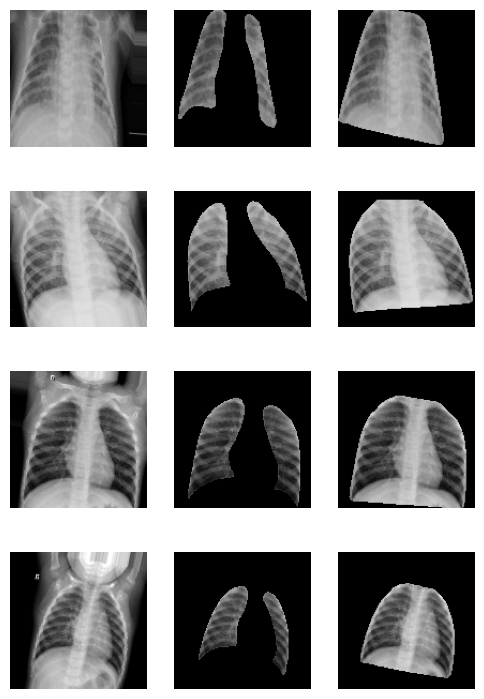

In [6]:
!rm -rf /kaggle/working/*

def save_result(path, cxr, ch0, ch1, name):
    cxr = (cxr * 255).astype(np.uint8)
    save_path = os.path.join(path, name + '_cxr.png')
    cv2.imwrite(save_path, cxr)
    
    ch0 = (ch0 * 255).astype(np.uint8)
    save_path = os.path.join(path, name + '_ch0.png')
    cv2.imwrite(save_path, ch0)

    ch1 = (ch1 * 255).astype(np.uint8)
    save_path = os.path.join(path, name + '_ch1.png')
    cv2.imwrite(save_path, ch1)

def read_result(path, name):
    read_path = os.path.join(path, name + '_cxr.png')
    cxr = cv2.imread(read_path)
    
    read_path = os.path.join(path, name + '_ch0.png')
    ch0 = cv2.imread(read_path)
    
    read_path = os.path.join(path, name + '_ch1.png')
    ch1 = cv2.imread(read_path)
    
    return cxr, ch0, ch1

fig, axs = plt.subplots(4, 3, figsize=(6, 9))

idx = 0
save_result('/kaggle/working/', x_train_cxr[idx], x_train_ch0[idx], x_train_ch1[idx], str(idx))
cxr, ch0, ch1 = read_result('/kaggle/working/', str(idx))
# axs[1, 0].set_title('X-ray Image')
axs[0, 0].imshow(cxr, cmap='gray')
axs[0, 0].axis('off')
# axs[1, 1].set_title('Segmented X-ray Image')
axs[0, 1].imshow(ch0, cmap='gray')
axs[0, 1].axis('off')
# axs[1, 2].set_title('Segmented X-ray Image with Convex Hull')
axs[0, 2].imshow(ch1, cmap='gray')
axs[0, 2].axis('off')

idx = 1
save_result('/kaggle/working/', x_train_cxr[idx], x_train_ch0[idx], x_train_ch1[idx], str(idx))
cxr, ch0, ch1 = read_result('/kaggle/working/', str(idx))
# axs[1, 0].set_title('X-ray Image')
axs[1, 0].imshow(cxr, cmap='gray')
axs[1, 0].axis('off')
# axs[1, 1].set_title('Segmented X-ray Image')
axs[1, 1].imshow(ch0, cmap='gray')
axs[1, 1].axis('off')
# axs[1, 2].set_title('Segmented X-ray Image with Convex Hull')
axs[1, 2].imshow(ch1, cmap='gray')
axs[1, 2].axis('off')

idx = 2
save_result('/kaggle/working/', x_train_cxr[idx], x_train_ch0[idx], x_train_ch1[idx], str(idx))
cxr, ch0, ch1 = read_result('/kaggle/working/', str(idx))
# axs[1, 0].set_title('X-ray Image')
axs[2, 0].imshow(cxr, cmap='gray')
axs[2, 0].axis('off')
# axs[1, 1].set_title('Segmented X-ray Image')
axs[2, 1].imshow(ch0, cmap='gray')
axs[2, 1].axis('off')
# axs[1, 2].set_title('Segmented X-ray Image with Convex Hull')
axs[2, 2].imshow(ch1, cmap='gray')
axs[2, 2].axis('off')

idx = 3
save_result('/kaggle/working/', x_train_cxr[idx], x_train_ch0[idx], x_train_ch1[idx], str(idx))
cxr, ch0, ch1 = read_result('/kaggle/working/', str(idx))
# axs[1, 0].set_title('X-ray Image')
axs[3, 0].imshow(cxr, cmap='gray')
axs[3, 0].axis('off')
# axs[1, 1].set_title('Segmented X-ray Image')
axs[3, 1].imshow(ch0, cmap='gray')
axs[3, 1].axis('off')
# axs[1, 2].set_title('Segmented X-ray Image with Convex Hull')
axs[3, 2].imshow(ch1, cmap='gray')
axs[3, 2].axis('off')

!rm -rf /kaggle/working/*

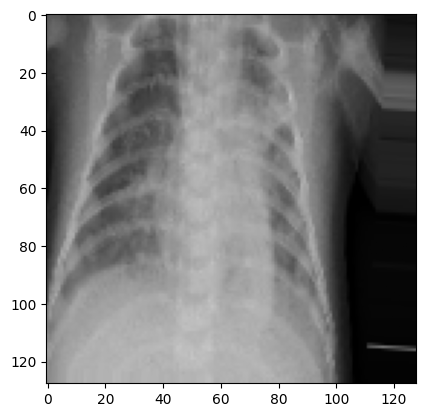

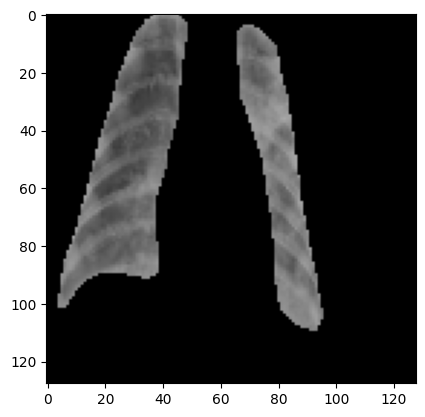

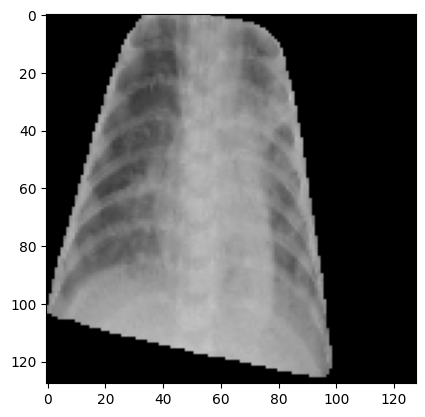

In [7]:
idx = 0
plt.imshow(x_train_rgb_cxr[idx])
plt.show()
plt.imshow(x_train_rgb_ch0[idx], cmap='gray')
plt.show()
plt.imshow(x_train_rgb_ch1[idx], cmap='gray')
plt.show()

# **FEATURES EXTRACTION**

In [8]:
fe_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x_train_feature_cxr = fe_model.predict(x_train_rgb_cxr, verbose=True).reshape(5232, -1)
x_train_feature_ch0 = fe_model.predict(x_train_rgb_ch0, verbose=True).reshape(5232, -1)
x_train_feature_ch1 = fe_model.predict(x_train_rgb_ch1, verbose=True).reshape(5232, -1)

x_test_feature_cxr = fe_model.predict(x_test_rgb_cxr, verbose=True).reshape(624, -1)
x_test_feature_ch0 = fe_model.predict(x_test_rgb_ch0, verbose=True).reshape(624, -1)
x_test_feature_ch1 = fe_model.predict(x_test_rgb_ch1, verbose=True).reshape(624, -1)

print(np.shape(x_train_feature_cxr))
print(np.shape(x_test_feature_cxr))

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(5232, 8192)
(624, 8192)


In [10]:
num_features = np.shape(x_train_feature_cxr)[1]

x_train_feature_cxr_df = pd.DataFrame(x_train_feature_cxr, columns=['feature_' + str(i) for i in range(num_features)])
x_train_feature_ch0_df = pd.DataFrame(x_train_feature_ch0, columns=['feature_' + str(i) for i in range(num_features)])
x_train_feature_ch1_df = pd.DataFrame(x_train_feature_ch1, columns=['feature_' + str(i) for i in range(num_features)])
y_train_df = pd.DataFrame(y_train.astype(np.int8), columns=['class'])

x_test_feature_cxr_df = pd.DataFrame(x_test_feature_cxr, columns=['feature_' + str(i) for i in range(num_features)])
x_test_feature_ch0_df = pd.DataFrame(x_test_feature_ch0, columns=['feature_' + str(i) for i in range(num_features)])
x_test_feature_ch1_df = pd.DataFrame(x_test_feature_ch1, columns=['feature_' + str(i) for i in range(num_features)])
y_test_df = pd.DataFrame(y_test.astype(np.int8), columns=['class'])

In [11]:
train_cxr_df = pd.concat([x_train_feature_cxr_df, y_train_df], axis=1)
train_ch0_df = pd.concat([x_train_feature_ch0_df, y_train_df], axis=1)
train_ch1_df = pd.concat([x_train_feature_ch1_df, y_train_df], axis=1)

test_cxr_df = pd.concat([x_test_feature_cxr_df, y_test_df], axis=1)
test_ch0_df = pd.concat([x_test_feature_ch0_df, y_test_df], axis=1)
test_ch1_df = pd.concat([x_test_feature_ch1_df, y_test_df], axis=1)

In [12]:
train_cxr_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_8183,feature_8184,feature_8185,feature_8186,feature_8187,feature_8188,feature_8189,feature_8190,feature_8191,class
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.109804,0.0,0.0,...,0.481577,0.119757,0.000000,0.000000,0.336190,0.431263,0.0,0.591651,0.0,1
1,0.0,0.0,0.223742,0.0,0.000000,0.0,0.0,0.153257,0.0,0.0,...,0.126655,0.824088,0.060858,0.150989,0.328201,0.000000,0.0,1.134346,0.0,1
2,0.0,0.0,0.000000,0.0,0.067386,0.0,0.0,0.257097,0.0,0.0,...,0.340753,0.214409,0.054033,0.671752,0.467557,0.000000,0.0,0.605260,0.0,0
3,0.0,0.0,0.000000,0.0,0.344554,0.0,0.0,0.000000,0.0,0.0,...,0.103324,0.138529,0.000000,0.191294,0.000000,0.000000,0.0,0.691551,0.0,0
4,0.0,0.0,0.324885,0.0,0.000000,0.0,0.0,0.017609,0.0,0.0,...,0.000000,0.473429,0.000000,0.129964,0.064341,0.000000,0.0,0.941175,0.0,0


In [13]:
save_path = '/kaggle/working/train/'
os.makedirs(save_path, exist_ok=True)
train_cxr_df.to_csv(os.path.join(save_path, 'cxr.csv'), index=False)
train_ch0_df.to_csv(os.path.join(save_path, 'segment.csv'), index=False)
train_ch1_df.to_csv(os.path.join(save_path, 'segment_with_convexhull.csv'), index=False)

save_path = '/kaggle/working/test/'
os.makedirs(save_path, exist_ok=True)
test_cxr_df.to_csv(os.path.join(save_path, 'cxr.csv'), index=False)
test_ch0_df.to_csv(os.path.join(save_path, 'segment.csv'), index=False)
test_ch1_df.to_csv(os.path.join(save_path, 'segment_with_convexhull.csv'), index=False)

In [14]:
# !rm -rf /kaggle/working/*